In [13]:
import numpy as np
import scanpy as sc
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, AlphaDropout, Lambda
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras import backend as K
from ivis.nn.losses import triplet_loss, is_categorical, is_multiclass, is_hinge
import bbknn
import pandas as pd
warnings.filterwarnings('ignore')

In [2]:
path = "/Users/lsimon/OneDrive/Miko/UTHealth/projects/BatchBalancedTriplets/data/time-series/WagnerEtAl/"
adata = sc.read(path + "combined_raw_counts.mtx").T

In [3]:
genes = pd.read_csv(path + "combined_raw_counts_genes.txt", header = None)
timepoints = pd.read_csv(path + "combined_raw_counts_timepoints.txt", header = None)

In [5]:
timepoint_unique = timepoints[0].unique().tolist()
timepoints = timepoints[0].tolist()
timepoint_num = []
for i in timepoints:
    timepoint_num.append(timepoint_unique.index(i))

In [6]:
adata.obs["timepoints"] = timepoint_num
adata.var_names = genes[0].tolist()

In [7]:
sc.pp.recipe_seurat(adata)

In [8]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

C:\Users\lsimon\AppData\Local\Continuum\anaconda3\lib\site-packages\numba\compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\AppData\Local\Continuum\anaconda3\lib\site-packages\umap\rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
C:\Users\lsimon\AppData\Local\Continuum\anaconda3\lib\site-packages\numba\compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\App

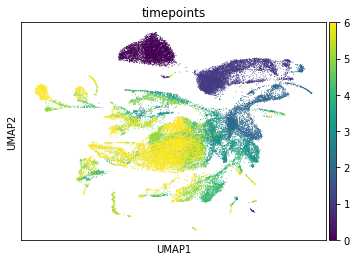

In [10]:
sc.pl.umap(adata, color = "timepoints")

In [11]:
def run_timeseries_bbtnn(adata,
                        timepoints = "timepoints",
                        neighbors_within_batch = 15,
                        n_pcs = 50,
                        epochs = 1000,
                        n_epochs_without_progress = 5,
                        batch_size = 32,
                        approx = False,
                        metric = "euclidean",
                        use_faiss = False,
                        n_trees = 50):
    
    # Define some functions
    def calculate_global_triplets(
        adata,
        timeseries,
        neighbors_within_batch = neighbors_within_batch,
        n_pcs = n_pcs,
        approx = True,
        metric = "euclidean",
        use_faiss = True,
        n_trees = 50):

        timepoints = adata.obs[timeseries]

        def Intersection(lst1, lst2):
            return set(lst1).intersection(lst2)

        unique_timepoints = np.unique(timepoints).tolist()
        list_of_timepoints = []
        for i in unique_timepoints:
            lst1 = list([i -1, i, i + 1])
            final_list = list(Intersection(lst1, unique_timepoints))
            list_of_timepoints.append(final_list)

        global_triplets = []
        for i in range(0, len(list_of_timepoints)):
            print("Timepoint " + str(i))
            adjacent_timepoints = list_of_timepoints[i]
            cells = adata.obs_names
            subm = adata[adata.obs[timeseries].isin(adjacent_timepoints)]
            cells_subm = subm.obs_names
            knn_distances, knn_indices = bbknn.get_graph(
                subm.obsm["X_pca"], batch_list = subm.obs[timeseries],
                neighbors_within_batch = neighbors_within_batch, n_pcs = n_pcs,
                approx = approx, metric = metric, use_faiss = use_faiss, n_trees = n_trees)

            sub_knn_distances = knn_distances[subm.obs[timeseries] == unique_timepoints[i],:]
            sub_knn_indices = knn_indices[subm.obs[timeseries] == unique_timepoints[i],:]    
            cells_subm_subm = cells_subm[subm.obs[timeseries] == unique_timepoints[i]]

            for j in range(0, sub_knn_indices.shape[0]):

                anchor = cells_subm_subm[j]
                neighbors = sub_knn_indices[j,:]

                positive = np.random.choice(cells_subm[neighbors], 1)[0]

                negative = np.random.choice(cells, 1)[0]

                global_triplets.append([anchor, positive, negative])
                
        return(global_triplets)
    
    # Calculate triplets across timepoints
    print("Calculating KNN triplets")
    global_triplets = calculate_global_triplets(adata=adata, timeseries=timepoints, n_pcs=n_pcs,
                                                neighbors_within_batch=neighbors_within_batch)
    print("Done!")
    
    # Get PCs for triplets
    print("Extract PCs for triplets")
    X = adata.obsm["X_pca"][:,0:n_pcs]
    
    anchors=[]
    positives=[]
    negatives=[]
    for i in global_triplets:
        anchors.append(i[0])
        positives.append(i[1])
        negatives.append(i[2])
        
    res = [adata.obs_names.tolist().index(i) for i in anchors]
    anchor = X[res,:]
    res = [adata.obs_names.tolist().index(i) for i in positives]
    positive = X[res,:]
    res = [adata.obs_names.tolist().index(i) for i in negatives]
    negative = X[res,:]
    print("Done!")
    
    # Define the model
    inputs = Input(X.shape[1])
    x = Dense(500, activation='selu',
              kernel_initializer='lecun_normal')(inputs)
    x = AlphaDropout(0.1)(x)
    x = Dense(500, activation='selu',
              kernel_initializer='lecun_normal')(x)
    x = AlphaDropout(0.1)(x)
    x = Dense(500, activation='selu', kernel_initializer='lecun_normal')(x)
    base_network = Model(inputs, x)

    def output_shape(shapes):
        shape1, shape2, shape3 = shapes
        return (3, shape1[0],)

    input_a = Input(shape=base_network.input_shape[1:])
    input_p = Input(shape=base_network.input_shape[1:])
    input_n = Input(shape=base_network.input_shape[1:])

    embeddings = Dense(2, kernel_regularizer = l1_l2(l1=0.1, l2=0.1))(base_network.output)
    network = Model(base_network.input, embeddings)

    processed_a = network(input_a)
    processed_p = network(input_p)
    processed_n = network(input_n)

    triplet = Lambda(K.stack,
                      output_shape=output_shape,
                      name='stacked_triplets')([processed_a,
                                                processed_p,
                                                processed_n],)
    model = Model([input_a, input_p, input_n], triplet)
    triplet_loss_func = triplet_loss(distance = "pn", margin = 1)
    model.compile(optimizer='adam', loss=triplet_loss_func)
    
    # Fit the model
    print("Fitting model")
    model.fit([anchor, positive, negative], epochs = epochs, batch_size = batch_size, verbose = 1,
        callbacks = [EarlyStopping(monitor = "loss", patience = n_epochs_without_progress)],
        shuffle = True)
    print("Done!")
    
    # Get the activations
    encoder = model.layers[3]
    embedding = encoder.predict(X, verbose=0)
    
    return(embedding)


In [17]:
tmp = run_timeseries_bbtnn(adata = adata, timepoints = "timepoints", neighbors_within_batch=15, batch_size=32)

Calculating KNN triplets
Timepoint 0
Timepoint 1
Timepoint 2
Timepoint 3
Timepoint 4
Timepoint 5
Timepoint 6
Done!
Extract PCs for triplets
Done!
Fitting model
Epoch 1/1000
36749/36749 [==============================] - ETA: 9:17 - loss: 6.848 - ETA: 1:01 - loss: 6.510 - ETA: 30s - loss: 6.191 - ETA: 21s - loss: 5.73 - ETA: 17s - loss: 5.29 - ETA: 14s - loss: 4.86 - ETA: 12s - loss: 4.42 - ETA: 11s - loss: 4.02 - ETA: 10s - loss: 3.68 - ETA: 9s - loss: 3.3744 - ETA: 8s - loss: 3.103 - ETA: 8s - loss: 2.849 - ETA: 7s - loss: 2.632 - ETA: 7s - loss: 2.444 - ETA: 7s - loss: 2.295 - ETA: 6s - loss: 2.168 - ETA: 6s - loss: 2.048 - ETA: 6s - loss: 1.947 - ETA: 6s - loss: 1.857 - ETA: 5s - loss: 1.776 - ETA: 5s - loss: 1.703 - ETA: 5s - loss: 1.638 - ETA: 5s - loss: 1.575 - ETA: 5s - loss: 1.527 - ETA: 5s - loss: 1.475 - ETA: 5s - loss: 1.433 - ETA: 4s - loss: 1.390 - ETA: 4s - loss: 1.351 - ETA: 4s - loss: 1.310 - ETA: 4s - loss: 1.276 - ETA: 4s - loss: 1.244 - ETA: 4s - loss: 1.215 - ETA: 4

36749/36749 [==============================] - ETA: 8s - loss: 0.116 - ETA: 5s - loss: 0.153 - ETA: 5s - loss: 0.180 - ETA: 5s - loss: 0.190 - ETA: 5s - loss: 0.192 - ETA: 5s - loss: 0.195 - ETA: 5s - loss: 0.198 - ETA: 5s - loss: 0.197 - ETA: 5s - loss: 0.200 - ETA: 5s - loss: 0.197 - ETA: 5s - loss: 0.197 - ETA: 5s - loss: 0.196 - ETA: 5s - loss: 0.198 - ETA: 5s - loss: 0.201 - ETA: 5s - loss: 0.202 - ETA: 5s - loss: 0.201 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.205 - ETA: 3s - loss: 0.207 - ETA: 3s - loss: 0.207 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.204 - ETA: 3s - loss: 0.204 - ETA: 3s - loss: 0

36749/36749 [==============================] - ETA: 8s - loss: 0.176 - ETA: 6s - loss: 0.183 - ETA: 6s - loss: 0.192 - ETA: 6s - loss: 0.185 - ETA: 6s - loss: 0.180 - ETA: 6s - loss: 0.178 - ETA: 5s - loss: 0.178 - ETA: 5s - loss: 0.186 - ETA: 5s - loss: 0.189 - ETA: 5s - loss: 0.188 - ETA: 5s - loss: 0.191 - ETA: 5s - loss: 0.189 - ETA: 5s - loss: 0.190 - ETA: 5s - loss: 0.187 - ETA: 5s - loss: 0.184 - ETA: 5s - loss: 0.182 - ETA: 5s - loss: 0.182 - ETA: 5s - loss: 0.181 - ETA: 5s - loss: 0.183 - ETA: 5s - loss: 0.181 - ETA: 4s - loss: 0.179 - ETA: 4s - loss: 0.180 - ETA: 4s - loss: 0.181 - ETA: 4s - loss: 0.181 - ETA: 4s - loss: 0.182 - ETA: 4s - loss: 0.183 - ETA: 4s - loss: 0.182 - ETA: 4s - loss: 0.184 - ETA: 4s - loss: 0.185 - ETA: 4s - loss: 0.184 - ETA: 4s - loss: 0.185 - ETA: 4s - loss: 0.184 - ETA: 4s - loss: 0.184 - ETA: 4s - loss: 0.184 - ETA: 4s - loss: 0.183 - ETA: 4s - loss: 0.182 - ETA: 4s - loss: 0.182 - ETA: 4s - loss: 0.181 - ETA: 3s - loss: 0.180 - ETA: 3s - loss: 0

36749/36749 [==============================] - ETA: 6s - loss: 0.066 - ETA: 5s - loss: 0.153 - ETA: 5s - loss: 0.158 - ETA: 5s - loss: 0.150 - ETA: 5s - loss: 0.156 - ETA: 5s - loss: 0.167 - ETA: 5s - loss: 0.169 - ETA: 5s - loss: 0.162 - ETA: 5s - loss: 0.162 - ETA: 5s - loss: 0.163 - ETA: 5s - loss: 0.160 - ETA: 5s - loss: 0.162 - ETA: 5s - loss: 0.166 - ETA: 5s - loss: 0.167 - ETA: 5s - loss: 0.166 - ETA: 5s - loss: 0.168 - ETA: 4s - loss: 0.164 - ETA: 4s - loss: 0.164 - ETA: 4s - loss: 0.162 - ETA: 4s - loss: 0.161 - ETA: 4s - loss: 0.162 - ETA: 4s - loss: 0.162 - ETA: 4s - loss: 0.162 - ETA: 4s - loss: 0.161 - ETA: 4s - loss: 0.162 - ETA: 4s - loss: 0.164 - ETA: 4s - loss: 0.164 - ETA: 4s - loss: 0.164 - ETA: 4s - loss: 0.163 - ETA: 4s - loss: 0.162 - ETA: 4s - loss: 0.161 - ETA: 4s - loss: 0.161 - ETA: 4s - loss: 0.162 - ETA: 4s - loss: 0.161 - ETA: 4s - loss: 0.162 - ETA: 3s - loss: 0.162 - ETA: 3s - loss: 0.162 - ETA: 3s - loss: 0.162 - ETA: 3s - loss: 0.162 - ETA: 3s - loss: 0

36749/36749 [==============================] - ETA: 6s - loss: 0.145 - ETA: 5s - loss: 0.141 - ETA: 5s - loss: 0.166 - ETA: 5s - loss: 0.168 - ETA: 5s - loss: 0.161 - ETA: 5s - loss: 0.155 - ETA: 5s - loss: 0.157 - ETA: 5s - loss: 0.156 - ETA: 5s - loss: 0.152 - ETA: 5s - loss: 0.147 - ETA: 5s - loss: 0.146 - ETA: 6s - loss: 0.147 - ETA: 6s - loss: 0.146 - ETA: 6s - loss: 0.150 - ETA: 6s - loss: 0.150 - ETA: 6s - loss: 0.149 - ETA: 6s - loss: 0.147 - ETA: 6s - loss: 0.145 - ETA: 6s - loss: 0.148 - ETA: 5s - loss: 0.148 - ETA: 5s - loss: 0.147 - ETA: 5s - loss: 0.150 - ETA: 5s - loss: 0.148 - ETA: 5s - loss: 0.148 - ETA: 5s - loss: 0.146 - ETA: 5s - loss: 0.145 - ETA: 5s - loss: 0.144 - ETA: 5s - loss: 0.144 - ETA: 5s - loss: 0.144 - ETA: 5s - loss: 0.145 - ETA: 5s - loss: 0.145 - ETA: 5s - loss: 0.145 - ETA: 5s - loss: 0.146 - ETA: 5s - loss: 0.146 - ETA: 5s - loss: 0.146 - ETA: 5s - loss: 0.145 - ETA: 5s - loss: 0.145 - ETA: 5s - loss: 0.145 - ETA: 4s - loss: 0.145 - ETA: 4s - loss: 0

36749/36749 [==============================] - ETA: 9s - loss: 0.090 - ETA: 6s - loss: 0.111 - ETA: 6s - loss: 0.122 - ETA: 6s - loss: 0.133 - ETA: 7s - loss: 0.126 - ETA: 7s - loss: 0.122 - ETA: 7s - loss: 0.121 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.127 - ETA: 8s - loss: 0.126 - ETA: 8s - loss: 0.124 - ETA: 8s - loss: 0.121 - ETA: 8s - loss: 0.121 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.115 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.117 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.119 - ETA: 7s - loss: 0

36749/36749 [==============================] - ETA: 13s - loss: 0.06 - ETA: 10s - loss: 0.12 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.12 - ETA: 9s - loss: 0.1271 - ETA: 9s - loss: 0.126 - ETA: 8s - loss: 0.125 - ETA: 8s - loss: 0.122 - ETA: 7s - loss: 0.123 - ETA: 7s - loss: 0.125 - ETA: 7s - loss: 0.124 - ETA: 7s - loss: 0.122 - ETA: 7s - loss: 0.125 - ETA: 7s - loss: 0.124 - ETA: 7s - loss: 0.123 - ETA: 7s - loss: 0.127 - ETA: 7s - loss: 0.127 - ETA: 7s - loss: 0.128 - ETA: 7s - loss: 0.126 - ETA: 7s - loss: 0.126 - ETA: 7s - loss: 0.126 - ETA: 7s - loss: 0.126 - ETA: 7s - loss: 0.127 - ETA: 7s - loss: 0.126 - ETA: 7s - loss: 0.126 - ETA: 7s - loss: 0.125 - ETA: 7s - loss: 0.124 - ETA: 7s - loss: 0.124 - ETA: 7s - loss: 0.123 - ETA: 7s - loss: 0.124 - ETA: 7s - loss: 0.124 - ETA: 7s - loss: 0.124 - ETA: 7s - loss: 0.124 - ETA: 7s - loss: 0.123 - ETA: 7s - loss: 0.124 - ETA: 7s - loss: 0.123 - ETA: 6s - loss: 0.124 - ETA: 6s - loss: 

36749/36749 [==============================] - ETA: 13s - loss: 0.12 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1087 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.112 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.116 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.117 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.117 - ETA: 7s - loss: 

36749/36749 [==============================] - ETA: 15s - loss: 0.21 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1196 - ETA: 9s - loss: 0.119 - ETA: 9s - loss: 0.123 - ETA: 9s - loss: 0.121 - ETA: 9s - loss: 0.124 - ETA: 8s - loss: 0.124 - ETA: 8s - loss: 0.124 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.124 - ETA: 7s - loss: 0.121 - ETA: 7s - loss: 0.120 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.117 - ETA: 7s - loss: 0.119 - ETA: 7s - loss: 0.119 - ETA: 7s - loss: 0.120 - ETA: 7s - loss: 0.119 - ETA: 7s - loss: 0.119 - ETA: 7s - loss: 0.120 - ETA: 7s - loss: 0.120 - ETA: 7s - loss: 0.120 - ETA: 7s - loss: 

36749/36749 [==============================] - ETA: 14s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1190 - ETA: 8s - loss: 0.124 - ETA: 7s - loss: 0.124 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.114 - ETA: 7s - loss: 0.117 - ETA: 7s - loss: 0.113 - ETA: 7s - loss: 0.114 - ETA: 7s - loss: 0.114 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.113 - ETA: 7s - loss: 0.114 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.117 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.117 - ETA: 7s - loss: 0.117 - ETA: 7s - loss: 0.117 - ETA: 7s - loss: 0.117 - ETA: 7s - loss: 

36749/36749 [==============================] - ETA: 11s - loss: 0.11 - ETA: 8s - loss: 0.1457 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.096 - ETA: 8s - loss: 0.095 - ETA: 8s - loss: 0.096 - ETA: 8s - loss: 0.099 - ETA: 8s - loss: 0.097 - ETA: 8s - loss: 0.098 - ETA: 8s - loss: 0.096 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.111 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.112 - ETA: 7s - loss: 0.112 - ETA: 7s - loss: 0.112 - ETA: 7s - loss: 0.111 - ETA: 6s - loss: 0.111 - ETA: 6s - loss: 0.110 - ETA: 6s - loss: 0.109 - ETA: 6s - loss: 0.110 - ETA: 6s - loss: 0.109 - ETA: 6s - loss: 0.109 - ETA: 6s - loss: 0.109 - ETA: 6s - loss: 0.108 - ETA: 6s - loss: 0.107 - ETA: 6s - loss: 

36749/36749 [==============================] - ETA: 6s - loss: 0.080 - ETA: 6s - loss: 0.093 - ETA: 7s - loss: 0.092 - ETA: 8s - loss: 0.084 - ETA: 7s - loss: 0.087 - ETA: 7s - loss: 0.093 - ETA: 7s - loss: 0.090 - ETA: 8s - loss: 0.091 - ETA: 7s - loss: 0.094 - ETA: 7s - loss: 0.096 - ETA: 7s - loss: 0.102 - ETA: 7s - loss: 0.104 - ETA: 7s - loss: 0.103 - ETA: 6s - loss: 0.103 - ETA: 6s - loss: 0.104 - ETA: 6s - loss: 0.102 - ETA: 6s - loss: 0.103 - ETA: 7s - loss: 0.101 - ETA: 7s - loss: 0.100 - ETA: 7s - loss: 0.100 - ETA: 7s - loss: 0.100 - ETA: 7s - loss: 0.099 - ETA: 7s - loss: 0.099 - ETA: 7s - loss: 0.100 - ETA: 7s - loss: 0.099 - ETA: 7s - loss: 0.099 - ETA: 7s - loss: 0.100 - ETA: 7s - loss: 0.100 - ETA: 7s - loss: 0.099 - ETA: 7s - loss: 0.098 - ETA: 7s - loss: 0.098 - ETA: 7s - loss: 0.098 - ETA: 7s - loss: 0.098 - ETA: 7s - loss: 0.098 - ETA: 7s - loss: 0.097 - ETA: 7s - loss: 0.097 - ETA: 7s - loss: 0.097 - ETA: 7s - loss: 0.097 - ETA: 7s - loss: 0.097 - ETA: 7s - loss: 0

36749/36749 [==============================] - ETA: 10s - loss: 0.02 - ETA: 6s - loss: 0.0887 - ETA: 7s - loss: 0.086 - ETA: 6s - loss: 0.087 - ETA: 7s - loss: 0.086 - ETA: 7s - loss: 0.086 - ETA: 7s - loss: 0.089 - ETA: 8s - loss: 0.086 - ETA: 8s - loss: 0.089 - ETA: 8s - loss: 0.093 - ETA: 8s - loss: 0.092 - ETA: 8s - loss: 0.093 - ETA: 8s - loss: 0.091 - ETA: 8s - loss: 0.092 - ETA: 8s - loss: 0.094 - ETA: 8s - loss: 0.096 - ETA: 8s - loss: 0.095 - ETA: 8s - loss: 0.094 - ETA: 8s - loss: 0.094 - ETA: 8s - loss: 0.095 - ETA: 8s - loss: 0.095 - ETA: 8s - loss: 0.094 - ETA: 8s - loss: 0.094 - ETA: 8s - loss: 0.093 - ETA: 8s - loss: 0.093 - ETA: 8s - loss: 0.092 - ETA: 8s - loss: 0.091 - ETA: 8s - loss: 0.091 - ETA: 8s - loss: 0.090 - ETA: 8s - loss: 0.090 - ETA: 8s - loss: 0.089 - ETA: 8s - loss: 0.090 - ETA: 8s - loss: 0.091 - ETA: 7s - loss: 0.091 - ETA: 7s - loss: 0.091 - ETA: 7s - loss: 0.091 - ETA: 7s - loss: 0.090 - ETA: 7s - loss: 0.090 - ETA: 7s - loss: 0.089 - ETA: 7s - loss: 

36749/36749 [==============================] - ETA: 9s - loss: 0.051 - ETA: 6s - loss: 0.055 - ETA: 6s - loss: 0.075 - ETA: 7s - loss: 0.073 - ETA: 7s - loss: 0.070 - ETA: 7s - loss: 0.063 - ETA: 7s - loss: 0.062 - ETA: 7s - loss: 0.060 - ETA: 7s - loss: 0.063 - ETA: 7s - loss: 0.063 - ETA: 7s - loss: 0.063 - ETA: 7s - loss: 0.065 - ETA: 7s - loss: 0.067 - ETA: 7s - loss: 0.067 - ETA: 7s - loss: 0.068 - ETA: 7s - loss: 0.071 - ETA: 7s - loss: 0.071 - ETA: 7s - loss: 0.071 - ETA: 7s - loss: 0.070 - ETA: 6s - loss: 0.071 - ETA: 6s - loss: 0.072 - ETA: 6s - loss: 0.072 - ETA: 6s - loss: 0.071 - ETA: 6s - loss: 0.075 - ETA: 6s - loss: 0.077 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0.077 - ETA: 6s - loss: 0.077 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0.079 - ETA: 6s - loss: 0.080 - ETA: 6s - loss: 0.080 - ETA: 6s - loss: 0.080 - ETA: 6s - loss: 0.081 - ETA: 5s - loss: 0

36749/36749 [==============================] - ETA: 9s - loss: 0.057 - ETA: 7s - loss: 0.054 - ETA: 8s - loss: 0.060 - ETA: 7s - loss: 0.066 - ETA: 7s - loss: 0.066 - ETA: 7s - loss: 0.070 - ETA: 7s - loss: 0.069 - ETA: 6s - loss: 0.074 - ETA: 6s - loss: 0.078 - ETA: 7s - loss: 0.078 - ETA: 7s - loss: 0.080 - ETA: 7s - loss: 0.080 - ETA: 7s - loss: 0.079 - ETA: 7s - loss: 0.080 - ETA: 7s - loss: 0.080 - ETA: 7s - loss: 0.080 - ETA: 7s - loss: 0.080 - ETA: 7s - loss: 0.080 - ETA: 6s - loss: 0.080 - ETA: 6s - loss: 0.080 - ETA: 6s - loss: 0.080 - ETA: 6s - loss: 0.081 - ETA: 6s - loss: 0.080 - ETA: 6s - loss: 0.079 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0.077 - ETA: 6s - loss: 0.077 - ETA: 6s - loss: 0.076 - ETA: 6s - loss: 0.076 - ETA: 6s - loss: 0.076 - ETA: 6s - loss: 0.076 - ETA: 6s - loss: 0.076 - ETA: 6s - loss: 0.076 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0.079 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0.079 - ETA: 6s - loss: 0

36749/36749 [==============================] - ETA: 8s - loss: 0.033 - ETA: 6s - loss: 0.061 - ETA: 6s - loss: 0.070 - ETA: 6s - loss: 0.083 - ETA: 6s - loss: 0.081 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0.075 - ETA: 6s - loss: 0.072 - ETA: 6s - loss: 0.070 - ETA: 6s - loss: 0.071 - ETA: 7s - loss: 0.072 - ETA: 7s - loss: 0.073 - ETA: 6s - loss: 0.074 - ETA: 6s - loss: 0.071 - ETA: 6s - loss: 0.070 - ETA: 6s - loss: 0.072 - ETA: 6s - loss: 0.074 - ETA: 6s - loss: 0.074 - ETA: 6s - loss: 0.076 - ETA: 6s - loss: 0.076 - ETA: 6s - loss: 0.076 - ETA: 6s - loss: 0.076 - ETA: 6s - loss: 0.075 - ETA: 6s - loss: 0.075 - ETA: 6s - loss: 0.075 - ETA: 6s - loss: 0.074 - ETA: 6s - loss: 0.073 - ETA: 6s - loss: 0.075 - ETA: 6s - loss: 0.077 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0.077 - ETA: 6s - loss: 0.077 - ETA: 6s - loss: 0.077 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0

36749/36749 [==============================] - ETA: 9s - loss: 0.042 - ETA: 6s - loss: 0.066 - ETA: 7s - loss: 0.074 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.069 - ETA: 9s - loss: 0.066 - ETA: 9s - loss: 0.067 - ETA: 9s - loss: 0.069 - ETA: 9s - loss: 0.070 - ETA: 9s - loss: 0.068 - ETA: 9s - loss: 0.065 - ETA: 9s - loss: 0.065 - ETA: 9s - loss: 0.065 - ETA: 9s - loss: 0.064 - ETA: 9s - loss: 0.065 - ETA: 9s - loss: 0.067 - ETA: 9s - loss: 0.067 - ETA: 9s - loss: 0.067 - ETA: 8s - loss: 0.068 - ETA: 8s - loss: 0.072 - ETA: 8s - loss: 0.072 - ETA: 8s - loss: 0.073 - ETA: 8s - loss: 0.073 - ETA: 8s - loss: 0.071 - ETA: 8s - loss: 0.071 - ETA: 8s - loss: 0.069 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.070 - ETA: 8s - loss: 0.069 - ETA: 8s - loss: 0.069 - ETA: 8s - loss: 0.071 - ETA: 8s - loss: 0.072 - ETA: 7s - loss: 0.072 - ETA: 7s - loss: 0.072 - ETA: 7s - loss: 0.071 - ETA: 7s - loss: 0.070 - ETA: 7s - loss: 0.070 - ETA: 7s - loss: 0.070 - ETA: 7s - loss: 0.070 - ETA: 7s - loss: 0

36749/36749 [==============================] - ETA: 7s - loss: 0.029 - ETA: 7s - loss: 0.065 - ETA: 7s - loss: 0.059 - ETA: 8s - loss: 0.061 - ETA: 8s - loss: 0.061 - ETA: 8s - loss: 0.060 - ETA: 8s - loss: 0.064 - ETA: 8s - loss: 0.063 - ETA: 8s - loss: 0.060 - ETA: 9s - loss: 0.059 - ETA: 8s - loss: 0.058 - ETA: 8s - loss: 0.060 - ETA: 9s - loss: 0.059 - ETA: 8s - loss: 0.057 - ETA: 8s - loss: 0.058 - ETA: 8s - loss: 0.057 - ETA: 8s - loss: 0.058 - ETA: 8s - loss: 0.057 - ETA: 8s - loss: 0.058 - ETA: 8s - loss: 0.060 - ETA: 8s - loss: 0.060 - ETA: 8s - loss: 0.059 - ETA: 8s - loss: 0.059 - ETA: 8s - loss: 0.059 - ETA: 8s - loss: 0.060 - ETA: 8s - loss: 0.060 - ETA: 8s - loss: 0.060 - ETA: 8s - loss: 0.060 - ETA: 8s - loss: 0.059 - ETA: 8s - loss: 0.060 - ETA: 8s - loss: 0.060 - ETA: 8s - loss: 0.061 - ETA: 8s - loss: 0.061 - ETA: 8s - loss: 0.062 - ETA: 8s - loss: 0.062 - ETA: 7s - loss: 0.062 - ETA: 7s - loss: 0.062 - ETA: 7s - loss: 0.063 - ETA: 7s - loss: 0.063 - ETA: 7s - loss: 0

Epoch 33/1000
36749/36749 [==============================] - ETA: 5s - loss: 0.066 - ETA: 6s - loss: 0.076 - ETA: 5s - loss: 0.073 - ETA: 5s - loss: 0.077 - ETA: 5s - loss: 0.079 - ETA: 5s - loss: 0.079 - ETA: 5s - loss: 0.076 - ETA: 6s - loss: 0.076 - ETA: 6s - loss: 0.073 - ETA: 6s - loss: 0.071 - ETA: 6s - loss: 0.071 - ETA: 7s - loss: 0.069 - ETA: 7s - loss: 0.069 - ETA: 7s - loss: 0.067 - ETA: 7s - loss: 0.067 - ETA: 7s - loss: 0.066 - ETA: 7s - loss: 0.066 - ETA: 7s - loss: 0.066 - ETA: 7s - loss: 0.065 - ETA: 7s - loss: 0.065 - ETA: 7s - loss: 0.067 - ETA: 7s - loss: 0.066 - ETA: 7s - loss: 0.068 - ETA: 7s - loss: 0.067 - ETA: 7s - loss: 0.067 - ETA: 7s - loss: 0.067 - ETA: 7s - loss: 0.066 - ETA: 7s - loss: 0.066 - ETA: 7s - loss: 0.065 - ETA: 7s - loss: 0.066 - ETA: 7s - loss: 0.066 - ETA: 7s - loss: 0.065 - ETA: 7s - loss: 0.066 - ETA: 7s - loss: 0.066 - ETA: 7s - loss: 0.066 - ETA: 7s - loss: 0.066 - ETA: 7s - loss: 0.066 - ETA: 7s - loss: 0.065 - ETA: 7s - loss: 0.065 - ETA

36749/36749 [==============================] - ETA: 10s - loss: 0.16 - ETA: 6s - loss: 0.0492 - ETA: 6s - loss: 0.046 - ETA: 6s - loss: 0.058 - ETA: 6s - loss: 0.058 - ETA: 6s - loss: 0.059 - ETA: 6s - loss: 0.056 - ETA: 5s - loss: 0.058 - ETA: 5s - loss: 0.058 - ETA: 5s - loss: 0.059 - ETA: 5s - loss: 0.057 - ETA: 5s - loss: 0.057 - ETA: 5s - loss: 0.055 - ETA: 5s - loss: 0.055 - ETA: 5s - loss: 0.054 - ETA: 5s - loss: 0.056 - ETA: 5s - loss: 0.056 - ETA: 5s - loss: 0.056 - ETA: 5s - loss: 0.056 - ETA: 5s - loss: 0.055 - ETA: 5s - loss: 0.054 - ETA: 5s - loss: 0.055 - ETA: 5s - loss: 0.054 - ETA: 5s - loss: 0.053 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 0.055 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 

36749/36749 [==============================] - ETA: 6s - loss: 0.027 - ETA: 5s - loss: 0.049 - ETA: 6s - loss: 0.041 - ETA: 5s - loss: 0.049 - ETA: 6s - loss: 0.050 - ETA: 6s - loss: 0.049 - ETA: 6s - loss: 0.048 - ETA: 6s - loss: 0.049 - ETA: 5s - loss: 0.050 - ETA: 5s - loss: 0.049 - ETA: 5s - loss: 0.052 - ETA: 5s - loss: 0.053 - ETA: 5s - loss: 0.054 - ETA: 5s - loss: 0.054 - ETA: 5s - loss: 0.054 - ETA: 5s - loss: 0.052 - ETA: 5s - loss: 0.052 - ETA: 5s - loss: 0.052 - ETA: 5s - loss: 0.052 - ETA: 4s - loss: 0.052 - ETA: 4s - loss: 0.052 - ETA: 4s - loss: 0.051 - ETA: 4s - loss: 0.051 - ETA: 4s - loss: 0.051 - ETA: 4s - loss: 0.052 - ETA: 4s - loss: 0.053 - ETA: 4s - loss: 0.053 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 0.055 - ETA: 4s - loss: 0.055 - ETA: 4s - loss: 0.055 - ETA: 4s - loss: 0.056 - ETA: 4s - loss: 0.056 - ETA: 4s - loss: 0.057 - ETA: 4s - loss: 0

36749/36749 [==============================] - ETA: 4s - loss: 0.064 - ETA: 5s - loss: 0.067 - ETA: 5s - loss: 0.071 - ETA: 5s - loss: 0.073 - ETA: 6s - loss: 0.068 - ETA: 6s - loss: 0.074 - ETA: 6s - loss: 0.073 - ETA: 6s - loss: 0.069 - ETA: 6s - loss: 0.071 - ETA: 6s - loss: 0.069 - ETA: 6s - loss: 0.070 - ETA: 6s - loss: 0.071 - ETA: 6s - loss: 0.069 - ETA: 6s - loss: 0.067 - ETA: 6s - loss: 0.068 - ETA: 6s - loss: 0.067 - ETA: 6s - loss: 0.066 - ETA: 6s - loss: 0.069 - ETA: 6s - loss: 0.067 - ETA: 6s - loss: 0.066 - ETA: 5s - loss: 0.066 - ETA: 5s - loss: 0.064 - ETA: 5s - loss: 0.063 - ETA: 5s - loss: 0.063 - ETA: 5s - loss: 0.063 - ETA: 5s - loss: 0.063 - ETA: 5s - loss: 0.062 - ETA: 5s - loss: 0.061 - ETA: 5s - loss: 0.061 - ETA: 5s - loss: 0.061 - ETA: 5s - loss: 0.060 - ETA: 5s - loss: 0.060 - ETA: 5s - loss: 0.061 - ETA: 5s - loss: 0.060 - ETA: 5s - loss: 0.060 - ETA: 5s - loss: 0.060 - ETA: 5s - loss: 0.059 - ETA: 5s - loss: 0.059 - ETA: 5s - loss: 0.059 - ETA: 5s - loss: 0

36749/36749 [==============================] - ETA: 9s - loss: 0.086 - ETA: 11s - loss: 0.04 - ETA: 9s - loss: 0.0607 - ETA: 8s - loss: 0.072 - ETA: 8s - loss: 0.067 - ETA: 9s - loss: 0.068 - ETA: 8s - loss: 0.064 - ETA: 8s - loss: 0.060 - ETA: 8s - loss: 0.058 - ETA: 8s - loss: 0.056 - ETA: 8s - loss: 0.055 - ETA: 8s - loss: 0.059 - ETA: 8s - loss: 0.060 - ETA: 8s - loss: 0.058 - ETA: 8s - loss: 0.057 - ETA: 8s - loss: 0.057 - ETA: 8s - loss: 0.055 - ETA: 8s - loss: 0.057 - ETA: 8s - loss: 0.056 - ETA: 8s - loss: 0.056 - ETA: 8s - loss: 0.055 - ETA: 8s - loss: 0.056 - ETA: 8s - loss: 0.056 - ETA: 8s - loss: 0.056 - ETA: 8s - loss: 0.056 - ETA: 8s - loss: 0.056 - ETA: 8s - loss: 0.056 - ETA: 8s - loss: 0.056 - ETA: 8s - loss: 0.055 - ETA: 8s - loss: 0.055 - ETA: 8s - loss: 0.056 - ETA: 7s - loss: 0.056 - ETA: 7s - loss: 0.056 - ETA: 7s - loss: 0.056 - ETA: 7s - loss: 0.056 - ETA: 7s - loss: 0.055 - ETA: 7s - loss: 0.055 - ETA: 7s - loss: 0.054 - ETA: 7s - loss: 0.055 - ETA: 7s - loss: 

36749/36749 [==============================] - ETA: 11s - loss: 0.02 - ETA: 10s - loss: 0.03 - ETA: 8s - loss: 0.0493 - ETA: 8s - loss: 0.054 - ETA: 9s - loss: 0.051 - ETA: 9s - loss: 0.054 - ETA: 9s - loss: 0.056 - ETA: 9s - loss: 0.054 - ETA: 9s - loss: 0.052 - ETA: 8s - loss: 0.053 - ETA: 8s - loss: 0.054 - ETA: 8s - loss: 0.053 - ETA: 8s - loss: 0.052 - ETA: 8s - loss: 0.051 - ETA: 8s - loss: 0.053 - ETA: 8s - loss: 0.053 - ETA: 8s - loss: 0.053 - ETA: 8s - loss: 0.052 - ETA: 8s - loss: 0.054 - ETA: 8s - loss: 0.053 - ETA: 7s - loss: 0.055 - ETA: 7s - loss: 0.054 - ETA: 7s - loss: 0.056 - ETA: 7s - loss: 0.056 - ETA: 7s - loss: 0.056 - ETA: 7s - loss: 0.057 - ETA: 7s - loss: 0.057 - ETA: 7s - loss: 0.058 - ETA: 7s - loss: 0.057 - ETA: 7s - loss: 0.056 - ETA: 7s - loss: 0.056 - ETA: 7s - loss: 0.055 - ETA: 7s - loss: 0.055 - ETA: 7s - loss: 0.055 - ETA: 7s - loss: 0.054 - ETA: 7s - loss: 0.054 - ETA: 7s - loss: 0.053 - ETA: 7s - loss: 0.054 - ETA: 7s - loss: 0.054 - ETA: 7s - loss: 

36749/36749 [==============================] - ETA: 8s - loss: 0.022 - ETA: 7s - loss: 0.058 - ETA: 8s - loss: 0.059 - ETA: 8s - loss: 0.060 - ETA: 8s - loss: 0.056 - ETA: 8s - loss: 0.051 - ETA: 8s - loss: 0.055 - ETA: 8s - loss: 0.054 - ETA: 7s - loss: 0.053 - ETA: 7s - loss: 0.052 - ETA: 7s - loss: 0.054 - ETA: 7s - loss: 0.053 - ETA: 7s - loss: 0.052 - ETA: 7s - loss: 0.053 - ETA: 7s - loss: 0.053 - ETA: 7s - loss: 0.052 - ETA: 7s - loss: 0.052 - ETA: 7s - loss: 0.052 - ETA: 7s - loss: 0.053 - ETA: 7s - loss: 0.052 - ETA: 7s - loss: 0.052 - ETA: 7s - loss: 0.051 - ETA: 7s - loss: 0.051 - ETA: 7s - loss: 0.050 - ETA: 7s - loss: 0.052 - ETA: 7s - loss: 0.052 - ETA: 7s - loss: 0.052 - ETA: 7s - loss: 0.052 - ETA: 7s - loss: 0.051 - ETA: 7s - loss: 0.052 - ETA: 7s - loss: 0.052 - ETA: 7s - loss: 0.051 - ETA: 7s - loss: 0.050 - ETA: 7s - loss: 0.050 - ETA: 7s - loss: 0.051 - ETA: 7s - loss: 0.051 - ETA: 7s - loss: 0.051 - ETA: 7s - loss: 0.051 - ETA: 7s - loss: 0.050 - ETA: 7s - loss: 0

36749/36749 [==============================] - ETA: 7s - loss: 0.075 - ETA: 6s - loss: 0.045 - ETA: 6s - loss: 0.040 - ETA: 6s - loss: 0.037 - ETA: 6s - loss: 0.041 - ETA: 6s - loss: 0.042 - ETA: 6s - loss: 0.043 - ETA: 6s - loss: 0.047 - ETA: 6s - loss: 0.047 - ETA: 6s - loss: 0.045 - ETA: 6s - loss: 0.047 - ETA: 6s - loss: 0.048 - ETA: 5s - loss: 0.050 - ETA: 5s - loss: 0.049 - ETA: 5s - loss: 0.049 - ETA: 5s - loss: 0.051 - ETA: 5s - loss: 0.050 - ETA: 5s - loss: 0.051 - ETA: 5s - loss: 0.051 - ETA: 5s - loss: 0.050 - ETA: 5s - loss: 0.052 - ETA: 5s - loss: 0.052 - ETA: 5s - loss: 0.052 - ETA: 5s - loss: 0.052 - ETA: 5s - loss: 0.051 - ETA: 5s - loss: 0.053 - ETA: 5s - loss: 0.053 - ETA: 5s - loss: 0.053 - ETA: 5s - loss: 0.052 - ETA: 6s - loss: 0.052 - ETA: 6s - loss: 0.052 - ETA: 5s - loss: 0.053 - ETA: 6s - loss: 0.054 - ETA: 5s - loss: 0.056 - ETA: 5s - loss: 0.058 - ETA: 5s - loss: 0.060 - ETA: 5s - loss: 0.061 - ETA: 5s - loss: 0.061 - ETA: 5s - loss: 0.062 - ETA: 5s - loss: 0

36749/36749 [==============================] - ETA: 6s - loss: 0.028 - ETA: 6s - loss: 0.039 - ETA: 6s - loss: 0.041 - ETA: 7s - loss: 0.039 - ETA: 6s - loss: 0.043 - ETA: 7s - loss: 0.041 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.038 - ETA: 6s - loss: 0.038 - ETA: 6s - loss: 0.040 - ETA: 6s - loss: 0.040 - ETA: 6s - loss: 0.039 - ETA: 6s - loss: 0.042 - ETA: 6s - loss: 0.042 - ETA: 6s - loss: 0.042 - ETA: 6s - loss: 0.042 - ETA: 6s - loss: 0.042 - ETA: 6s - loss: 0.043 - ETA: 6s - loss: 0.043 - ETA: 6s - loss: 0.044 - ETA: 6s - loss: 0.043 - ETA: 6s - loss: 0.043 - ETA: 6s - loss: 0.043 - ETA: 6s - loss: 0.043 - ETA: 6s - loss: 0.044 - ETA: 6s - loss: 0.044 - ETA: 6s - loss: 0.044 - ETA: 5s - loss: 0.044 - ETA: 5s - loss: 0.044 - ETA: 5s - loss: 0.044 - ETA: 5s - loss: 0.044 - ETA: 5s - loss: 0.045 - ETA: 5s - loss: 0

36749/36749 [==============================] - ETA: 15s - loss: 0.02 - ETA: 9s - loss: 0.0339 - ETA: 7s - loss: 0.049 - ETA: 7s - loss: 0.051 - ETA: 7s - loss: 0.048 - ETA: 7s - loss: 0.048 - ETA: 7s - loss: 0.050 - ETA: 7s - loss: 0.053 - ETA: 7s - loss: 0.054 - ETA: 7s - loss: 0.057 - ETA: 7s - loss: 0.054 - ETA: 7s - loss: 0.051 - ETA: 7s - loss: 0.052 - ETA: 7s - loss: 0.052 - ETA: 7s - loss: 0.052 - ETA: 7s - loss: 0.050 - ETA: 7s - loss: 0.049 - ETA: 7s - loss: 0.050 - ETA: 7s - loss: 0.051 - ETA: 7s - loss: 0.052 - ETA: 7s - loss: 0.052 - ETA: 7s - loss: 0.053 - ETA: 7s - loss: 0.054 - ETA: 7s - loss: 0.054 - ETA: 7s - loss: 0.054 - ETA: 7s - loss: 0.055 - ETA: 7s - loss: 0.054 - ETA: 7s - loss: 0.055 - ETA: 7s - loss: 0.054 - ETA: 7s - loss: 0.055 - ETA: 7s - loss: 0.054 - ETA: 7s - loss: 0.054 - ETA: 6s - loss: 0.054 - ETA: 6s - loss: 0.053 - ETA: 6s - loss: 0.053 - ETA: 6s - loss: 0.053 - ETA: 6s - loss: 0.053 - ETA: 6s - loss: 0.052 - ETA: 6s - loss: 0.052 - ETA: 6s - loss: 

36749/36749 [==============================] - ETA: 6s - loss: 0.060 - ETA: 6s - loss: 0.066 - ETA: 7s - loss: 0.054 - ETA: 7s - loss: 0.053 - ETA: 8s - loss: 0.052 - ETA: 7s - loss: 0.048 - ETA: 7s - loss: 0.046 - ETA: 7s - loss: 0.046 - ETA: 7s - loss: 0.046 - ETA: 7s - loss: 0.044 - ETA: 7s - loss: 0.047 - ETA: 7s - loss: 0.048 - ETA: 7s - loss: 0.047 - ETA: 8s - loss: 0.047 - ETA: 8s - loss: 0.046 - ETA: 8s - loss: 0.046 - ETA: 8s - loss: 0.045 - ETA: 8s - loss: 0.045 - ETA: 8s - loss: 0.044 - ETA: 8s - loss: 0.045 - ETA: 7s - loss: 0.044 - ETA: 7s - loss: 0.043 - ETA: 7s - loss: 0.045 - ETA: 7s - loss: 0.044 - ETA: 7s - loss: 0.045 - ETA: 7s - loss: 0.045 - ETA: 7s - loss: 0.045 - ETA: 7s - loss: 0.045 - ETA: 7s - loss: 0.046 - ETA: 7s - loss: 0.046 - ETA: 7s - loss: 0.045 - ETA: 7s - loss: 0.045 - ETA: 7s - loss: 0.045 - ETA: 7s - loss: 0.044 - ETA: 7s - loss: 0.044 - ETA: 7s - loss: 0.044 - ETA: 7s - loss: 0.044 - ETA: 7s - loss: 0.044 - ETA: 7s - loss: 0.044 - ETA: 7s - loss: 0

36749/36749 [==============================] - ETA: 5s - loss: 0.167 - ETA: 5s - loss: 0.049 - ETA: 6s - loss: 0.052 - ETA: 7s - loss: 0.051 - ETA: 7s - loss: 0.048 - ETA: 8s - loss: 0.046 - ETA: 7s - loss: 0.043 - ETA: 7s - loss: 0.044 - ETA: 7s - loss: 0.044 - ETA: 7s - loss: 0.044 - ETA: 7s - loss: 0.045 - ETA: 7s - loss: 0.048 - ETA: 7s - loss: 0.048 - ETA: 7s - loss: 0.048 - ETA: 7s - loss: 0.048 - ETA: 7s - loss: 0.047 - ETA: 7s - loss: 0.047 - ETA: 7s - loss: 0.047 - ETA: 7s - loss: 0.049 - ETA: 7s - loss: 0.050 - ETA: 7s - loss: 0.050 - ETA: 7s - loss: 0.049 - ETA: 7s - loss: 0.049 - ETA: 7s - loss: 0.049 - ETA: 7s - loss: 0.049 - ETA: 7s - loss: 0.048 - ETA: 7s - loss: 0.048 - ETA: 7s - loss: 0.048 - ETA: 7s - loss: 0.050 - ETA: 7s - loss: 0.050 - ETA: 7s - loss: 0.050 - ETA: 7s - loss: 0.049 - ETA: 7s - loss: 0.049 - ETA: 7s - loss: 0.050 - ETA: 7s - loss: 0.050 - ETA: 7s - loss: 0.050 - ETA: 6s - loss: 0.051 - ETA: 6s - loss: 0.051 - ETA: 6s - loss: 0.050 - ETA: 6s - loss: 0

36749/36749 [==============================] - ETA: 8s - loss: 0.026 - ETA: 6s - loss: 0.136 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.110 - ETA: 8s - loss: 0.106 - ETA: 7s - loss: 0.098 - ETA: 7s - loss: 0.089 - ETA: 7s - loss: 0.083 - ETA: 7s - loss: 0.078 - ETA: 7s - loss: 0.076 - ETA: 6s - loss: 0.073 - ETA: 6s - loss: 0.069 - ETA: 6s - loss: 0.068 - ETA: 6s - loss: 0.067 - ETA: 6s - loss: 0.066 - ETA: 6s - loss: 0.063 - ETA: 6s - loss: 0.061 - ETA: 6s - loss: 0.060 - ETA: 6s - loss: 0.059 - ETA: 6s - loss: 0.058 - ETA: 6s - loss: 0.058 - ETA: 6s - loss: 0.057 - ETA: 6s - loss: 0.056 - ETA: 6s - loss: 0.056 - ETA: 6s - loss: 0.056 - ETA: 7s - loss: 0.056 - ETA: 7s - loss: 0.057 - ETA: 7s - loss: 0.058 - ETA: 7s - loss: 0.058 - ETA: 7s - loss: 0.057 - ETA: 7s - loss: 0.056 - ETA: 6s - loss: 0.056 - ETA: 6s - loss: 0.055 - ETA: 6s - loss: 0.055 - ETA: 6s - loss: 0.055 - ETA: 6s - loss: 0.056 - ETA: 6s - loss: 0.056 - ETA: 6s - loss: 0.056 - ETA: 6s - loss: 0.055 - ETA: 6s - loss: 0

36749/36749 [==============================] - ETA: 9s - loss: 0.023 - ETA: 8s - loss: 0.058 - ETA: 8s - loss: 0.046 - ETA: 8s - loss: 0.042 - ETA: 8s - loss: 0.044 - ETA: 8s - loss: 0.043 - ETA: 8s - loss: 0.043 - ETA: 9s - loss: 0.042 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.040 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.039 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.038 - ETA: 6s - loss: 0.037 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 6s - loss: 0.040 - ETA: 6s - loss: 0.040 - ETA: 6s - loss: 0.040 - ETA: 6s - loss: 0.039 - ETA: 6s - loss: 0.040 - ETA: 6s - loss: 0.040 - ETA: 6s - loss: 0.039 - ETA: 6s - loss: 0.039 - ETA: 6s - loss: 0.039 - ETA: 6s - loss: 0

36749/36749 [==============================] - ETA: 8s - loss: 0.021 - ETA: 5s - loss: 0.038 - ETA: 6s - loss: 0.033 - ETA: 6s - loss: 0.034 - ETA: 6s - loss: 0.032 - ETA: 6s - loss: 0.034 - ETA: 6s - loss: 0.036 - ETA: 6s - loss: 0.039 - ETA: 6s - loss: 0.040 - ETA: 6s - loss: 0.039 - ETA: 6s - loss: 0.038 - ETA: 6s - loss: 0.038 - ETA: 6s - loss: 0.040 - ETA: 6s - loss: 0.042 - ETA: 6s - loss: 0.045 - ETA: 6s - loss: 0.047 - ETA: 6s - loss: 0.049 - ETA: 6s - loss: 0.050 - ETA: 6s - loss: 0.051 - ETA: 6s - loss: 0.050 - ETA: 6s - loss: 0.050 - ETA: 6s - loss: 0.050 - ETA: 6s - loss: 0.049 - ETA: 6s - loss: 0.049 - ETA: 6s - loss: 0.050 - ETA: 6s - loss: 0.050 - ETA: 6s - loss: 0.050 - ETA: 6s - loss: 0.049 - ETA: 6s - loss: 0.049 - ETA: 6s - loss: 0.050 - ETA: 6s - loss: 0.050 - ETA: 5s - loss: 0.050 - ETA: 5s - loss: 0.050 - ETA: 5s - loss: 0.050 - ETA: 5s - loss: 0.049 - ETA: 5s - loss: 0.049 - ETA: 5s - loss: 0.049 - ETA: 5s - loss: 0.048 - ETA: 5s - loss: 0.048 - ETA: 5s - loss: 0

36749/36749 [==============================] - ETA: 13s - loss: 0.04 - ETA: 10s - loss: 0.03 - ETA: 8s - loss: 0.0306 - ETA: 8s - loss: 0.031 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.039 - ETA: 8s - loss: 0.043 - ETA: 8s - loss: 0.044 - ETA: 7s - loss: 0.043 - ETA: 7s - loss: 0.042 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.042 - ETA: 8s - loss: 0.042 - ETA: 8s - loss: 0.042 - ETA: 8s - loss: 0.042 - ETA: 8s - loss: 0.042 - ETA: 8s - loss: 0.043 - ETA: 8s - loss: 0.042 - ETA: 7s - loss: 0.041 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 

36749/36749 [==============================] - ETA: 8s - loss: 0.047 - ETA: 11s - loss: 0.04 - ETA: 10s - loss: 0.03 - ETA: 9s - loss: 0.0359 - ETA: 9s - loss: 0.038 - ETA: 9s - loss: 0.038 - ETA: 9s - loss: 0.038 - ETA: 9s - loss: 0.036 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.034 - ETA: 8s - loss: 0.034 - ETA: 7s - loss: 0.034 - ETA: 7s - loss: 0.034 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 6s - loss: 0.036 - ETA: 6s - loss: 0.036 - ETA: 6s - loss: 0.036 - ETA: 6s - loss: 0.037 - ETA: 6s - loss: 0.037 - ETA: 6s - loss: 0.037 - ETA: 6s - loss: 0.037 - ETA: 6s - loss: 0.038 - ETA: 6s - loss: 

36749/36749 [==============================] - ETA: 8s - loss: 0.027 - ETA: 6s - loss: 0.054 - ETA: 7s - loss: 0.043 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.040 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.034 - ETA: 8s - loss: 0.034 - ETA: 8s - loss: 0.034 - ETA: 8s - loss: 0.034 - ETA: 8s - loss: 0.034 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.038 - ETA: 8s - loss: 0.038 - ETA: 8s - loss: 0.038 - ETA: 8s - loss: 0.038 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.038 - ETA: 8s - loss: 0.038 - ETA: 8s - loss: 0.038 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0

36749/36749 [==============================] - ETA: 3s - loss: 0.021 - ETA: 6s - loss: 0.041 - ETA: 6s - loss: 0.039 - ETA: 6s - loss: 0.038 - ETA: 6s - loss: 0.034 - ETA: 6s - loss: 0.032 - ETA: 6s - loss: 0.031 - ETA: 6s - loss: 0.031 - ETA: 6s - loss: 0.030 - ETA: 6s - loss: 0.029 - ETA: 6s - loss: 0.029 - ETA: 6s - loss: 0.028 - ETA: 6s - loss: 0.028 - ETA: 6s - loss: 0.029 - ETA: 6s - loss: 0.029 - ETA: 6s - loss: 0.029 - ETA: 6s - loss: 0.030 - ETA: 6s - loss: 0.030 - ETA: 6s - loss: 0.029 - ETA: 6s - loss: 0.031 - ETA: 6s - loss: 0.031 - ETA: 6s - loss: 0.033 - ETA: 6s - loss: 0.035 - ETA: 6s - loss: 0.037 - ETA: 7s - loss: 0.044 - ETA: 7s - loss: 0.045 - ETA: 7s - loss: 0.047 - ETA: 7s - loss: 0.047 - ETA: 6s - loss: 0.048 - ETA: 6s - loss: 0.048 - ETA: 6s - loss: 0.048 - ETA: 6s - loss: 0.047 - ETA: 6s - loss: 0.047 - ETA: 6s - loss: 0.047 - ETA: 6s - loss: 0.048 - ETA: 6s - loss: 0.047 - ETA: 6s - loss: 0.047 - ETA: 6s - loss: 0.048 - ETA: 6s - loss: 0.048 - ETA: 6s - loss: 0

36749/36749 [==============================] - ETA: 15s - loss: 0.02 - ETA: 10s - loss: 0.06 - ETA: 9s - loss: 0.0511 - ETA: 9s - loss: 0.043 - ETA: 9s - loss: 0.040 - ETA: 9s - loss: 0.037 - ETA: 9s - loss: 0.038 - ETA: 9s - loss: 0.036 - ETA: 9s - loss: 0.035 - ETA: 9s - loss: 0.036 - ETA: 9s - loss: 0.037 - ETA: 9s - loss: 0.035 - ETA: 9s - loss: 0.035 - ETA: 8s - loss: 0.038 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.038 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 

36749/36749 [==============================] - ETA: 8s - loss: 0.022 - ETA: 7s - loss: 0.033 - ETA: 8s - loss: 0.029 - ETA: 8s - loss: 0.033 - ETA: 9s - loss: 0.033 - ETA: 9s - loss: 0.035 - ETA: 9s - loss: 0.035 - ETA: 9s - loss: 0.033 - ETA: 9s - loss: 0.034 - ETA: 9s - loss: 0.035 - ETA: 9s - loss: 0.034 - ETA: 8s - loss: 0.032 - ETA: 8s - loss: 0.033 - ETA: 8s - loss: 0.033 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.034 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.034 - ETA: 7s - loss: 0.034 - ETA: 7s - loss: 0.034 - ETA: 7s - loss: 0.034 - ETA: 7s - loss: 0.034 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0

36749/36749 [==============================] - ETA: 7s - loss: 0.021 - ETA: 6s - loss: 0.035 - ETA: 6s - loss: 0.032 - ETA: 6s - loss: 0.039 - ETA: 7s - loss: 0.048 - ETA: 8s - loss: 0.048 - ETA: 8s - loss: 0.045 - ETA: 8s - loss: 0.046 - ETA: 8s - loss: 0.044 - ETA: 8s - loss: 0.046 - ETA: 8s - loss: 0.044 - ETA: 8s - loss: 0.043 - ETA: 8s - loss: 0.043 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.043 - ETA: 8s - loss: 0.044 - ETA: 8s - loss: 0.044 - ETA: 8s - loss: 0.043 - ETA: 8s - loss: 0.042 - ETA: 8s - loss: 0.041 - ETA: 7s - loss: 0.042 - ETA: 7s - loss: 0.043 - ETA: 7s - loss: 0.042 - ETA: 7s - loss: 0.042 - ETA: 7s - loss: 0.042 - ETA: 7s - loss: 0.042 - ETA: 7s - loss: 0.042 - ETA: 7s - loss: 0.042 - ETA: 7s - loss: 0.042 - ETA: 7s - loss: 0.042 - ETA: 7s - loss: 0.042 - ETA: 7s - loss: 0.041 - ETA: 7s - loss: 0.041 - ETA: 7s - loss: 0.041 - ETA: 7s - loss: 0.041 - ETA: 7s - loss: 0.042 - ETA: 7s - loss: 0.042 - ETA: 7s - loss: 0.042 - ETA: 7s - loss: 0.042 - ETA: 7s - loss: 0

36749/36749 [==============================] - ETA: 8s - loss: 0.021 - ETA: 8s - loss: 0.022 - ETA: 8s - loss: 0.023 - ETA: 8s - loss: 0.030 - ETA: 9s - loss: 0.029 - ETA: 9s - loss: 0.028 - ETA: 9s - loss: 0.030 - ETA: 9s - loss: 0.029 - ETA: 9s - loss: 0.029 - ETA: 9s - loss: 0.028 - ETA: 9s - loss: 0.028 - ETA: 9s - loss: 0.027 - ETA: 9s - loss: 0.027 - ETA: 9s - loss: 0.027 - ETA: 9s - loss: 0.027 - ETA: 9s - loss: 0.028 - ETA: 9s - loss: 0.029 - ETA: 9s - loss: 0.029 - ETA: 9s - loss: 0.029 - ETA: 9s - loss: 0.029 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.031 - ETA: 8s - loss: 0.031 - ETA: 8s - loss: 0.031 - ETA: 8s - loss: 0.031 - ETA: 8s - loss: 0.031 - ETA: 8s - loss: 0.031 - ETA: 8s - loss: 0.031 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.030 - ETA: 7s - loss: 0.030 - ETA: 7s - loss: 0.030 - ETA: 7s - loss: 0.030 - ETA: 7s - loss: 0.030 - ETA: 7s - loss: 0.030 - ETA: 7s - loss: 0.029 - ETA: 7s - loss: 0.029 - ETA: 7s - loss: 0

36749/36749 [==============================] - ETA: 10s - loss: 0.02 - ETA: 7s - loss: 0.0299 - ETA: 8s - loss: 0.030 - ETA: 9s - loss: 0.036 - ETA: 9s - loss: 0.039 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.038 - ETA: 9s - loss: 0.037 - ETA: 9s - loss: 0.038 - ETA: 9s - loss: 0.037 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.034 - ETA: 8s - loss: 0.033 - ETA: 8s - loss: 0.034 - ETA: 8s - loss: 0.034 - ETA: 8s - loss: 0.034 - ETA: 8s - loss: 0.034 - ETA: 8s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.032 - ETA: 7s - loss: 0.032 - ETA: 7s - loss: 0.032 - ETA: 7s - loss: 0.032 - ETA: 7s - loss: 0.032 - ETA: 7s - loss: 

36749/36749 [==============================] - ETA: 9s - loss: 0.021 - ETA: 8s - loss: 0.029 - ETA: 8s - loss: 0.034 - ETA: 9s - loss: 0.034 - ETA: 9s - loss: 0.033 - ETA: 9s - loss: 0.031 - ETA: 9s - loss: 0.036 - ETA: 9s - loss: 0.036 - ETA: 9s - loss: 0.035 - ETA: 9s - loss: 0.035 - ETA: 8s - loss: 0.034 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.034 - ETA: 8s - loss: 0.034 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.034 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.034 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.034 - ETA: 7s - loss: 0.034 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.034 - ETA: 7s - loss: 0

36749/36749 [==============================] - ETA: 14s - loss: 0.01 - ETA: 11s - loss: 0.02 - ETA: 10s - loss: 0.02 - ETA: 10s - loss: 0.02 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.02 - ETA: 10s - loss: 0.03 - ETA: 9s - loss: 0.0313 - ETA: 9s - loss: 0.032 - ETA: 9s - loss: 0.031 - ETA: 9s - loss: 0.031 - ETA: 9s - loss: 0.031 - ETA: 9s - loss: 0.032 - ETA: 9s - loss: 0.032 - ETA: 8s - loss: 0.031 - ETA: 8s - loss: 0.031 - ETA: 8s - loss: 0.031 - ETA: 8s - loss: 0.031 - ETA: 8s - loss: 0.031 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.031 - ETA: 8s - loss: 0.031 - ETA: 8s - loss: 0.031 - ETA: 8s - loss: 0.031 - ETA: 8s - loss: 0.031 - ETA: 8s - loss: 0.031 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.031 - ETA: 7s - loss: 0.031 - ETA: 7s - loss: 0.032 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.032 - ETA: 7s - loss: 

36749/36749 [==============================] - ETA: 15s - loss: 0.03 - ETA: 12s - loss: 0.04 - ETA: 11s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 9s - loss: 0.0389 - ETA: 8s - loss: 0.044 - ETA: 8s - loss: 0.042 - ETA: 8s - loss: 0.040 - ETA: 8s - loss: 0.040 - ETA: 8s - loss: 0.040 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.040 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.040 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.040 - ETA: 8s - loss: 0.040 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.038 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.038 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.040 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.039 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 

36749/36749 [==============================] - ETA: 12s - loss: 0.03 - ETA: 11s - loss: 0.05 - ETA: 11s - loss: 0.06 - ETA: 10s - loss: 0.05 - ETA: 10s - loss: 0.05 - ETA: 10s - loss: 0.05 - ETA: 10s - loss: 0.05 - ETA: 10s - loss: 0.05 - ETA: 10s - loss: 0.05 - ETA: 9s - loss: 0.0494 - ETA: 9s - loss: 0.049 - ETA: 9s - loss: 0.054 - ETA: 9s - loss: 0.053 - ETA: 9s - loss: 0.052 - ETA: 9s - loss: 0.052 - ETA: 9s - loss: 0.051 - ETA: 9s - loss: 0.049 - ETA: 8s - loss: 0.050 - ETA: 8s - loss: 0.049 - ETA: 8s - loss: 0.050 - ETA: 8s - loss: 0.050 - ETA: 8s - loss: 0.050 - ETA: 8s - loss: 0.050 - ETA: 8s - loss: 0.049 - ETA: 8s - loss: 0.048 - ETA: 8s - loss: 0.047 - ETA: 8s - loss: 0.047 - ETA: 8s - loss: 0.048 - ETA: 8s - loss: 0.048 - ETA: 8s - loss: 0.048 - ETA: 7s - loss: 0.048 - ETA: 7s - loss: 0.048 - ETA: 7s - loss: 0.047 - ETA: 7s - loss: 0.047 - ETA: 7s - loss: 0.046 - ETA: 7s - loss: 0.046 - ETA: 7s - loss: 0.046 - ETA: 7s - loss: 0.046 - ETA: 7s - loss: 0.046 - ETA: 7s - loss: 

36749/36749 [==============================] - ETA: 12s - loss: 0.02 - ETA: 10s - loss: 0.04 - ETA: 8s - loss: 0.0359 - ETA: 8s - loss: 0.039 - ETA: 9s - loss: 0.040 - ETA: 8s - loss: 0.044 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.040 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.038 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.038 - ETA: 8s - loss: 0.038 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.038 - ETA: 8s - loss: 0.038 - ETA: 8s - loss: 0.038 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.041 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.041 - ETA: 7s - loss: 0.041 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.041 - ETA: 7s - loss: 0.041 - ETA: 7s - loss: 0.041 - ETA: 7s - loss: 0.041 - ETA: 7s - loss: 

36749/36749 [==============================] - ETA: 7s - loss: 0.032 - ETA: 8s - loss: 0.025 - ETA: 9s - loss: 0.027 - ETA: 8s - loss: 0.027 - ETA: 9s - loss: 0.037 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.034 - ETA: 8s - loss: 0.034 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.034 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.036 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0

36749/36749 [==============================] - ETA: 6s - loss: 0.021 - ETA: 8s - loss: 0.023 - ETA: 8s - loss: 0.024 - ETA: 8s - loss: 0.023 - ETA: 8s - loss: 0.025 - ETA: 8s - loss: 0.024 - ETA: 8s - loss: 0.026 - ETA: 8s - loss: 0.025 - ETA: 8s - loss: 0.025 - ETA: 8s - loss: 0.028 - ETA: 8s - loss: 0.028 - ETA: 8s - loss: 0.028 - ETA: 8s - loss: 0.028 - ETA: 8s - loss: 0.027 - ETA: 8s - loss: 0.027 - ETA: 8s - loss: 0.027 - ETA: 8s - loss: 0.027 - ETA: 8s - loss: 0.027 - ETA: 8s - loss: 0.028 - ETA: 8s - loss: 0.028 - ETA: 8s - loss: 0.027 - ETA: 8s - loss: 0.028 - ETA: 8s - loss: 0.028 - ETA: 8s - loss: 0.029 - ETA: 7s - loss: 0.031 - ETA: 7s - loss: 0.032 - ETA: 7s - loss: 0.032 - ETA: 7s - loss: 0.032 - ETA: 7s - loss: 0.032 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0.033 - ETA: 7s - loss: 0

36749/36749 [==============================] - ETA: 14s - loss: 0.05 - ETA: 10s - loss: 0.02 - ETA: 9s - loss: 0.0257 - ETA: 9s - loss: 0.025 - ETA: 10s - loss: 0.02 - ETA: 9s - loss: 0.0243 - ETA: 10s - loss: 0.02 - ETA: 9s - loss: 0.0263 - ETA: 9s - loss: 0.028 - ETA: 9s - loss: 0.027 - ETA: 9s - loss: 0.026 - ETA: 9s - loss: 0.026 - ETA: 8s - loss: 0.029 - ETA: 8s - loss: 0.032 - ETA: 8s - loss: 0.032 - ETA: 8s - loss: 0.033 - ETA: 8s - loss: 0.033 - ETA: 8s - loss: 0.033 - ETA: 8s - loss: 0.034 - ETA: 8s - loss: 0.034 - ETA: 8s - loss: 0.035 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.037 - ETA: 8s - loss: 0.037 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.037 - ETA: 7s - loss

36749/36749 [==============================] - ETA: 16s - loss: 0.02 - ETA: 11s - loss: 0.06 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.05 - ETA: 10s - loss: 0.04 - ETA: 9s - loss: 0.0466 - ETA: 9s - loss: 0.043 - ETA: 9s - loss: 0.042 - ETA: 9s - loss: 0.044 - ETA: 9s - loss: 0.043 - ETA: 9s - loss: 0.042 - ETA: 9s - loss: 0.041 - ETA: 9s - loss: 0.039 - ETA: 9s - loss: 0.041 - ETA: 9s - loss: 0.040 - ETA: 9s - loss: 0.040 - ETA: 8s - loss: 0.040 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.040 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.042 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.040 - ETA: 8s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 

36749/36749 [==============================] - ETA: 9s - loss: 0.209 - ETA: 10s - loss: 0.06 - ETA: 9s - loss: 0.0504 - ETA: 9s - loss: 0.042 - ETA: 9s - loss: 0.042 - ETA: 9s - loss: 0.043 - ETA: 9s - loss: 0.041 - ETA: 9s - loss: 0.038 - ETA: 9s - loss: 0.037 - ETA: 9s - loss: 0.035 - ETA: 9s - loss: 0.033 - ETA: 9s - loss: 0.032 - ETA: 9s - loss: 0.031 - ETA: 9s - loss: 0.031 - ETA: 9s - loss: 0.030 - ETA: 9s - loss: 0.030 - ETA: 9s - loss: 0.031 - ETA: 9s - loss: 0.031 - ETA: 9s - loss: 0.031 - ETA: 9s - loss: 0.030 - ETA: 9s - loss: 0.030 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.030 - ETA: 8s - loss: 0.031 - ETA: 8s - loss: 0.031 - ETA: 7s - loss: 0.031 - ETA: 7s - loss: 

36749/36749 [==============================] - ETA: 9s - loss: 0.036 - ETA: 8s - loss: 0.086 - ETA: 9s - loss: 0.062 - ETA: 9s - loss: 0.052 - ETA: 9s - loss: 0.053 - ETA: 9s - loss: 0.049 - ETA: 9s - loss: 0.046 - ETA: 9s - loss: 0.049 - ETA: 9s - loss: 0.048 - ETA: 9s - loss: 0.048 - ETA: 8s - loss: 0.049 - ETA: 8s - loss: 0.048 - ETA: 8s - loss: 0.046 - ETA: 8s - loss: 0.044 - ETA: 8s - loss: 0.043 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.042 - ETA: 8s - loss: 0.042 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.040 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.039 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.035 - ETA: 7s - loss: 0.034 - ETA: 7s - loss: 0.034 - ETA: 7s - loss: 0.034 - ETA: 7s - loss: 0.034 - ETA: 7s - loss: 0

36749/36749 [==============================] - ETA: 9s - loss: 0.023 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.052 - ETA: 8s - loss: 0.045 - ETA: 8s - loss: 0.045 - ETA: 8s - loss: 0.042 - ETA: 8s - loss: 0.044 - ETA: 8s - loss: 0.049 - ETA: 8s - loss: 0.047 - ETA: 8s - loss: 0.046 - ETA: 8s - loss: 0.044 - ETA: 8s - loss: 0.044 - ETA: 8s - loss: 0.042 - ETA: 8s - loss: 0.042 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.042 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.040 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.039 - ETA: 8s - loss: 0.040 - ETA: 8s - loss: 0.040 - ETA: 8s - loss: 0.041 - ETA: 8s - loss: 0.041 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.038 - ETA: 7s - loss: 0

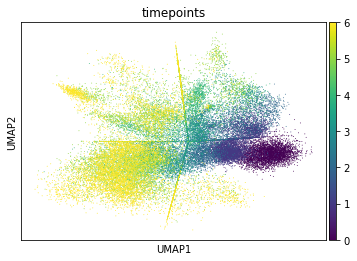

In [18]:
adata.obsm["X_umap"] = tmp
sc.pl.umap(adata, color = "timepoints")